In [1]:
import os
import ast
import urllib
import urllib2
import shapely
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors
from cStringIO import StringIO
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Query Carto DB function.
# Source: https://github.com/fedhere/
def queryCartoDB(query, f, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': f, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
# Select column to count on (ids) and zipcodes.
query = '''
SELECT COUNT(cartodb_id), zipcodes
FROM NYCAsthmasDismissals
GROUP BY zipcodes
'''

# Query Carto DB.
data = queryCartoDB(query, 'CSV', 'https://fb55.carto.com/api/v2/sql')

# Load data into pandas DataFrame.
df = pd.read_csv(data)
df.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [4]:
# Define function to download files to PUIDATA.
def curlfile(url, outfile):
    """Downloads file from url to PUIdata, returns output file path.
    Arguments:
    url - url location of descired file (string).
    outfile - name of downloaded file (string).
    """
    outfile = os.getenv('PUIDATA') + outfile
    os.system('curl -o ' + outfile + ' ' + url)
    return outfile

# Download file of NYC zipcode.
url = 'https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
curlfile(url, 'NYC_zipcodes.zip')

'/Users/JordanVani/Documents/NYU/PUI/PUIdata/NYC_zipcodes.zip'

In [5]:
# Define function to download files in PUIDATA.
def unzipPUIDATA(infile, outfolder):
    """Unzips file on PUIDATA, returns folder path.
    Arguments:
    infile - filename in PUIDATA
    outfolder - name of unzipped folder
    """
    infile = os.getenv('PUIDATA') + infile
    outfolder = os.getenv('PUIDATA') + outfolder + '/'
    os.system('unzip ' + infile + ' -d ' + outfolder)
    return outfolder

# Unzip file of NYC zipcodes.
z = unzipPUIDATA('NYC_zipcodes.zip', 'NYC_zipcodes')

In [6]:
# Load zipcode shapefile to geopandas.
shp = os.getenv('PUIDATA') + '/NYC_zipcodes/' + os.listdir(z)[4]
zips = gpd.GeoDataFrame.from_file(shp)

# Create centroid column.
zips['centroid'] = zips.geometry.centroid

# Create copy of geodataframe only with relevant columns.
zipc = zips[['ZIPCODE', 'centroid']].copy()

# Rename columns to match asthma data.
zipc.columns = ['zipcodes', 'centroid']

# Convert shapefile zipcode to num type.
zipc.zipcodes = zipc.zipcodes.astype(int)

# Inner join shapefile and asthma data.
data = df.merge(zipc, how='inner', on='zipcodes')

In [7]:
# Turn merged dataframe back to geodataframe.
# Reassign centroid as geometry column.
data = gpd.GeoDataFrame(data).set_geometry('centroid')

# Define function to extract x and y coordinates.
def getXY(pt):
    return (pt.x, pt.y)

# Create x & y lists of zipped coordinates.
x, y = [list(t) for t in zip(*map(getXY, data['centroid'].centroid))]

# Append x & y lists as columns.
data['x'] = x
data['y'] = y

# Convert pandas dataframe to numpy array.
krigdata = data.as_matrix(['x', 'y', 'count'])

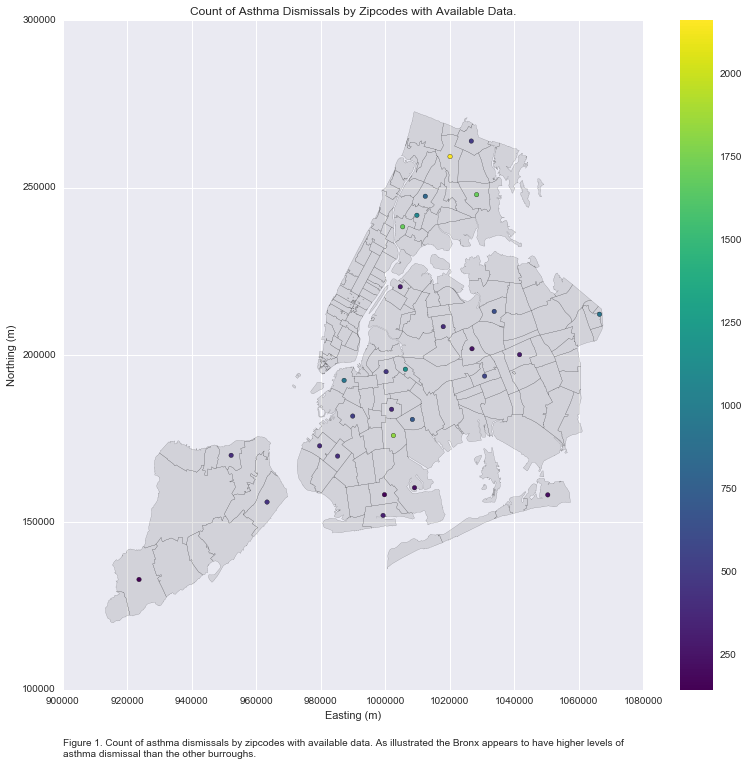

In [8]:
#Plot asthma points
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(13, 12))
pl.scatter(krigdata[:, 0], krigdata[:, 1], c=krigdata[:, 2],
          s=20, cmap='viridis', zorder=2)
zips.plot(ax=ax1, linewidth=0.1, zorder=1, color='k', 
         alpha=0.1)
ax1.set_ylabel('Northing (m)')
ax1.set_xlabel('Easting (m)')
ax1.set_title('Count of Asthma Dismissals by Zipcodes with Available Data.')
ax1.text(900000, 80000, 'Figure 1. Count of asthma dismissals by zipcodes with available data.' +
        ' As illustrated the Bronx appears to have higher levels of \nasthma dismissal than ' + 
        'the other burroughs.')

# Add color bar.
normalize = mcolors.Normalize(vmin=krigdata[:, 2].min(), vmax=krigdata[:, 2].max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cm.viridis)
scalarmappaple.set_array(krigdata[:, 2])
pl.colorbar(scalarmappaple, ax=ax1)

In [9]:
# Define function to calculate semivariogram.
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )

def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append(SVh( P, h, bw ))
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [[hs[i], sv[i]] for i in range(len(hs)) if sv[i] > 0]
    return np.array(sv).T

In [10]:
mysv = SV(krigdata, np.arange(0, 10000, 100), 500)
mysv.shape

(2, 49)

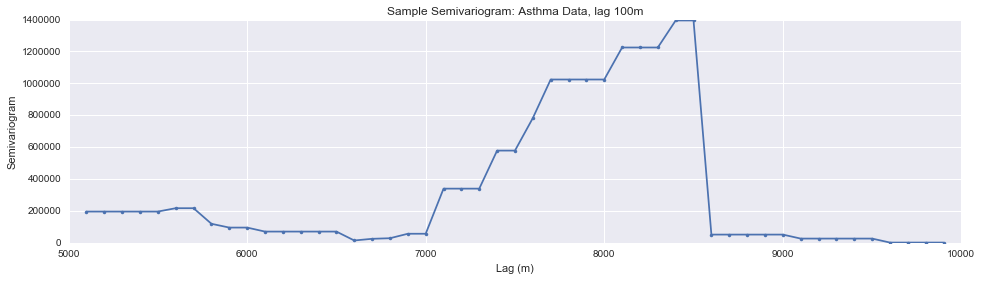

In [11]:
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax1.plot(mysv[0], mysv[1], '.-' )
ax1.set_xlabel('Lag (m)')
ax1.set_ylabel('Semivariogram')
ax1.set_title('Sample Semivariogram: Asthma Data, lag 100m') 

In [12]:
# different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

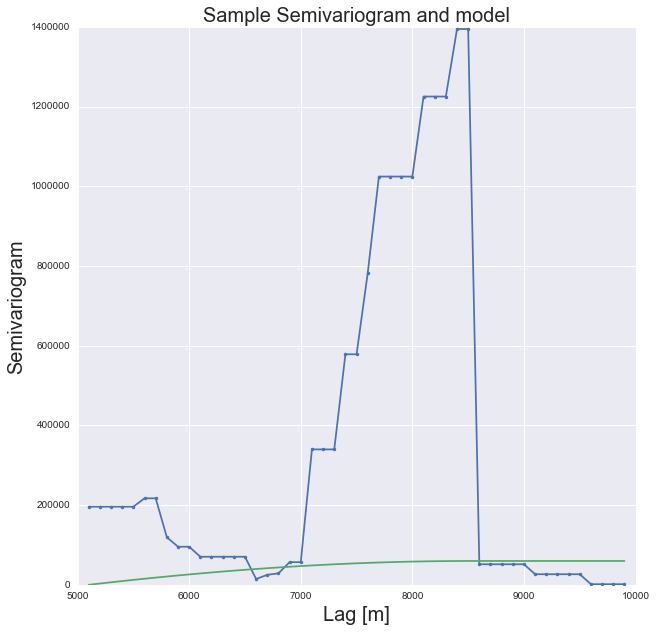

In [13]:
bw = 500
pl.figure(figsize=(10,10))
sp = cvmodel(krigdata, model=spherical, 
             hs=np.arange(0, 10000, 100 ), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
pl.plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram and model', fontsize=20) ;

In [14]:
def krige( P, model, hs, bw, u, N ):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
    # covariance function
    covfct = cvmodel( P, model, hs, bw )
    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return float( estimation )

In [15]:
import time
print time.localtime()
hs = np.arange(0, 10500, 100)

x0, x1 = krigdata[:,0].min(), krigdata[:,0].max()
y0, y1 = krigdata[:,1].min(), krigdata[:,1].max()
z = np.zeros((8,10))
dx, dy = (x1-x0)/z.shape[1], (y1-y0)/z.shape[0]

for i in range(z.shape[0]):
    print i
    for j in range(z.shape[1]):
        z[i][j] = krige(krigdata, spherical, hs, bw, (dy*j,dx*i), 3)
        
print time.localtime()

time.struct_time(tm_year=2016, tm_mon=12, tm_mday=11, tm_hour=21, tm_min=38, tm_sec=51, tm_wday=6, tm_yday=346, tm_isdst=0)
0
1
2
3
4
5
6
7
time.struct_time(tm_year=2016, tm_mon=12, tm_mday=11, tm_hour=21, tm_min=39, tm_sec=6, tm_wday=6, tm_yday=346, tm_isdst=0)


In [16]:
z

array([[ 691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483],
       [ 691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483],
       [ 691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483],
       [ 691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483],
       [ 691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483],
       [ 691.31034483,  691.31034483,  691.31034483,  691.31034483,
         691.31034483,  691.31034483,  691.31034483,  691

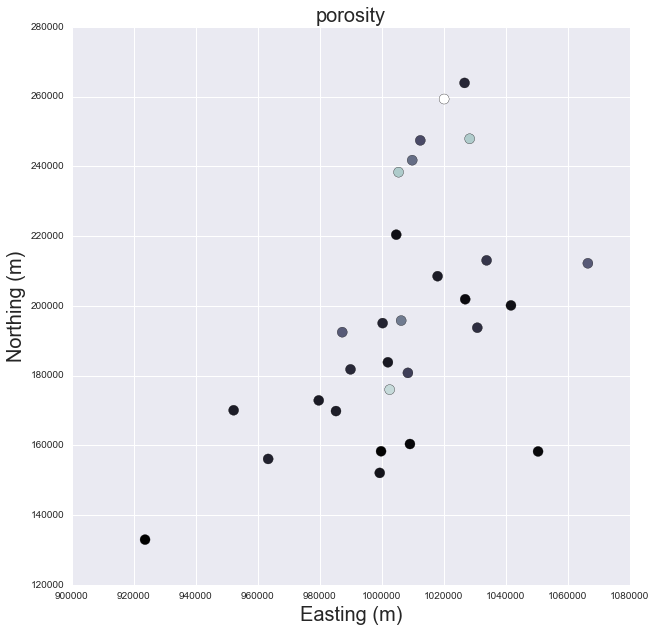

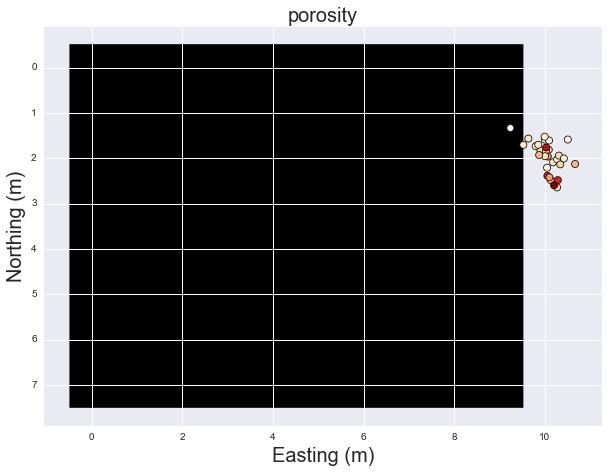

In [17]:
ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
ax.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
# ax.set_ylim(0, 17000)
# ax.set_xlim(0, 21000)
ax.set_xlabel("Easting (m)", fontsize=20)
ax.set_ylabel("Northing (m)", fontsize=20)
title = pl.title("porosity", fontsize=20)

ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
H = np.zeros_like(z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*3 )
ax.imshow(z, cmap='bone', interpolation='nearest' )
ax.scatter(krigdata[:,0] / 100000.0, krigdata[:,1] / 100000.0, c=krigdata[:,2], cmap='OrRd', 
           linewidths=0.75, s=50 )

#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
ax.set_xlabel("Easting (m)", fontsize=20)
ax.set_ylabel("Northing (m)", fontsize=20)
ax.set_title("porosity", fontsize=20)
# ax.set_xticks( [2,5.0,7], [5000,10000,15000] )
# ax.set_yticks( [2,5.0,7], [5000,10000,15000] )

<img src="A_For_Effort.png" width = '500'>